In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am
from utils import * 


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
L = 257
N = int(np.floor(np.log2(L)) - 1)

label = 'h_0.4_p_0.8_q_0.1'
file = open("data_{}.txt".format(label))

realisations, moments = read_file(file, verbose=True) 

#Parameters={ Seed: 5, Branching rate: 0.4, p : 0.8, q : 0.1, Realisations: 10, Chunk size: 10, Dimension: 2, (Max) Lattice size: 257, Graph Type: 0 }

#Version: #78d0

# Running for L = 257

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 

#Writing moments: 

# Info: count_full_resets=0 and count_cache_resets=10

#okely dokely!


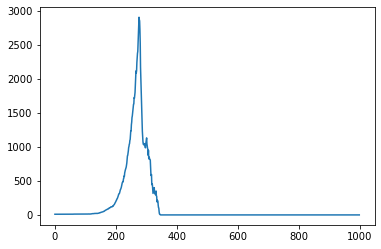

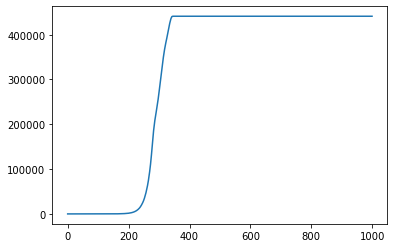

In [3]:
# print(moments)
active_moments, tracer_moments = extract_moments(moments)

plt.plot(active_moments[:, 2])
plt.show() 

plt.plot(tracer_moments[:, 2])
plt.show() 

In [4]:
times = [] 
msds = [] 
tot_edge_reach = 0 
tot_possible_edge = len(realisations)*4 
binder = np.zeros((N))

for (i, realisation) in enumerate(realisations):

    time, msd, edge_reach, coarse_grain_moments = extract_lite(realisation, N)
    times.append(time)
    msds.append(msd)
    tot_edge_reach += edge_reach 
    
    m2 = coarse_grain_moments[:, 2] 
    m4 = coarse_grain_moments[:, 4]
    binder += 1 - (m4/(3*m2*m2))

/Users/yutingli/Documents/Branching/BranchingWienerProcess-master/BARW/utils.py:50: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coarse_grain_moments = np.vstack(map(f, realisation[i+1:i+N+1]))


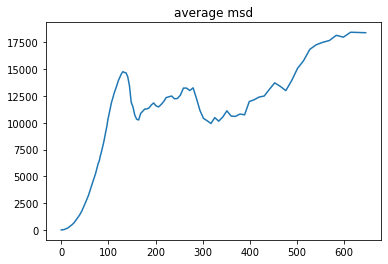

In [34]:
# plot average msd vs time 
t = select_longest(times)[:-1] 
mean_msd = np.mean(pad(msds), axis=0)
plt.title('average msd')
plt.plot(t, mean_msd)
plt.show() 